# How does the memorability of a movie evolve regarding his characteristics (gender of producer, gender of actors) ?

For question 2, we need to identify citations in quotebank for specific movies.

In [1]:
import pandas as pd
import numpy as np
import json
import bz2
import pickle
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [8]:
#a function to format dates

def parse_date(date):
    try:
        if not isinstance(date, str):
            return np.NaN
        elif len(date)%21 != 0:
            return np.NaN
        elif date == 'None' or date[0] == '-':
            return np.NaN
        elif '+0000-00-00T00:00:00Z' in date[0:21] :
            return '01.01.0001'
        elif '-00-00T00:00:00' in date[0:21] :
            return datetime.strptime(date[0:21], '+%Y-00-00T00:00:00Z').strftime('%d.%m.%Y')
        elif '-00T00:00:00' in date[0:21] :
            return datetime.strptime(date[0:21], '+%Y-%m-00T00:00:00Z').strftime('%d.%m.%Y')
        elif '+1939-02-29T00:00:00Z' in date:
            return '28.02.1939'
        else :
            return datetime.strptime(date[0:21], '+%Y-%m-%dT%H:%M:%SZ').strftime('%d.%m.%Y')
    except ValueError as e:
        if str(e) == 'day is out of range for month':
            return datetime.strptime(date[0:8], '+%Y-%m').strftime('%d.%m.%Y')
        else:
            print(date)
            raise e

## Task 1 
Load quotebank dataset previously filtered

In [40]:
path_to_file = '../generated/QUOTEBANK/moviefiltered_10tk_random.json.bz2'
path_to_out = '../temp/QUOTEBANK/moviefiltered_10tk_random_clean.json.bz2'

#drop columns that we don't need
with bz2.open(path_to_file, 'rb') as in_file:
    with bz2.open(path_to_out, 'wb') as out_file:
        for instance in in_file:
            instance = json.loads(instance)
            instance.pop('quotation', None)
            instance.pop('speaker', None)
            instance.pop('phase', None)
            out_file.write((json.dumps(instance)+'\n').encode('utf-8'))   

In [ ]:
movie_filtered_clean = pd.read_json(path_to_out, lines=True, compression='bz2')

In [ ]:
with open('generated/moviefiltered_10tk_random_clean_json.pickle', 'wb') as f: 
    pickle.dump(moviefiltered_clean, f)

In [ ]:
path = '../generated/QUOTEBANK/moviefiltered_10tk_random_clean.json.bz2'
film = {}

with bz2.open(path, 'rb') as f:  
    for instance in f:
        instance = json.loads(instance)
        if instance['film'] in film.keys():
            film[instance['film']] +=1
        else : 
            film[instance['film']] = 1

print(json.dumps(film, indent = 4))

In [ ]:
df_films = pd.DataFrame(list(film.items()),columns = ['Name','occ'])
df_films['occ'].sum()

In [ ]:
with open('../generated/QUOTEBANK/df_occ_films.pickle', 'rb') as f: 
    df_films = pickle.loads(f.read())
df_films.sort_values(by = 'occ', ascending = False)

# Filtre films

In [ ]:
df_films_filtred = df_films.sort_values(by = 'occ', ascending = False)
df_films_filtred.reset_index(drop = True, inplace = True)

On recherche le meilleur film de 2018 --> c'est Avengers Infinity War

Avengers Infinity War : 133 occurences.
Mais Venom, qui est un film très cool, est à 411.  

Donc on dégage tout ce qui est au dessus de 411.

In [45]:
upper_bound = 1068
df_films_filtred = df_films_filtred[(df_films_filtred['occ'] <= upper_bound) | (df_films_filtred['occ'].isna())]
df_films_filtred['occ'].sum()

2084416

In [ ]:
df_films_filtred.head(3)

In [48]:
good_films = list(df_films_filtred['Name'])

In [54]:
with open('../generated/QUOTEBANK/list_filtred_films.pickle', 'wb') as f: 
    pickle.dump(good_films, f)

In [115]:
with open('../generated/QUOTEBANK/list_filtred_films.pickle', 'rb') as f: 
    good_films = pickle.loads(f.read())
good_films[:5]

['Black_Panther', 'Leon', 'Sex', 'Rising', 'Ready']

In [ ]:
path_to_file = '../generated/QUOTEBANK/moviefiltered_10tk_clean.json.bz2'
path_to_out = '../temp/QUOTEBANK/movie_10tk_FILTERED.json.bz2'

with bz2.open(path_to_file, 'rb') as in_file:
    with bz2.open(path_to_out, 'wb') as out_file:
        for instance in in_file:
            instance = json.loads(instance)
            if instance['film'].replace('_', ' ') in good_films:
                out_file.write((json.dumps(instance)+'\n').encode('utf-8'))    

## Task 2 
For this task, add column of interest in the dataset : 
- release date
- gender perc
- ratings

To assign the gender, we decides that if more than 50% of actors are female, in concequence global gender is female. 

In [15]:
#format publicy_date from Wikidata to enrich data set
tconst_release_date = pd.read_json('../generated/QUOTEBANK/tconst_enriched_dict.json.bz2', 
                                   lines = True, 
                                   compression='bz2')


In [16]:
tconst_release_date['publicy_date'] = tconst_release_date['publicy_date'].map(parse_date)
tconst_release_date.rename(columns={'tconst' : 'id_film'}, inplace = True)
tconst_release_date.head()

,id_film,publicy_place,publicy_date
0,tt1675434,Q30,25.05.2012
1,tt0050083,Q30,10.04.1957
2,tt4168940,Unknown,14.01.1989
3,tt0074486,Unknown,01.01.1977
4,tt0056801,Unknown,14.02.1963


In [19]:
moviefiltered_enriched = pd.merge(moviefiltered_clean, tconst_release_date, on = 'id_film', how = 'left')
moviefiltered_enriched.drop(columns = ['publicy_place'], inplace = True)
moviefiltered_enriched

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_date
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,01.01.2011
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582,NaN
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323,NaN
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624,NaN
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474,NaN
...,...,...,...,...,...,...,...,...
1800830,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,01.01.2021
1800831,2018-04-10-152991,2018-10-04,2,male,None,Warcraft,tt0803096,01.06.2016
1800832,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792,NaN
1800833,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436,NaN


In [20]:
date_nan = moviefiltered_enriched[moviefiltered_enriched['publicy_date'].isna()]
print(f'{len(date_nan)} publicy date are missing')

1372191 publicy date are missing


__Discuss__ : Here we see the films that do not have a known release date in Wikidata. That is, they don't have a Wikipedia page. So it's assumed that these aren't important movies, so people don't talk about them as often as stated here (these are false positives). This is why we decide not to take them into account. 

In [ ]:
#delete films without publicy_date
moviefiltered_enriched = moviefiltered_enriched[moviefiltered_enriched['publicy_date'].notna()]
moviefiltered_enriched.head()

## Task 3

Determine features to estimate the memorability of a movie.

In [28]:
df_datetime = moviefiltered_enriched.copy()

In [29]:
#calculate column 'days', which is the number of day between release date and quote date
df_datetime['date'] = pd.to_datetime(df_datetime['date'], format = '%Y-%m-%d')
df_datetime['publicy_date'] = pd.to_datetime(df_datetime['publicy_date'], format = '%d.%m.%Y')

df_datetime['days'] = (df_datetime['date'] - df_datetime['publicy_date'])
df_datetime['days'] = df_datetime['days'].map(lambda x : x.days)
df_datetime

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_date,days
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,2011-01-01,2803
8,2018-05-20-000976,2018-05-20,2,female,15.03.1993,Raazi,tt7098658,2018-05-11,9
9,2018-11-12-002175,2018-12-11,1,male,01.01.1979,X.,tt6190456,2018-11-01,40
21,2018-03-13-004134,2018-03-13,1,male,None,Ranveer,tt9430574,2019-02-01,-325
25,2018-01-22-003803,2018-01-22,4,female,25.04.1998,Bando,tt8850222,2020-08-12,-933
...,...,...,...,...,...,...,...,...,...
1800820,2018-06-06-133240,2018-06-06,1,male,21.09.1950,Pollock,tt0183659,2000-01-01,6731
1800822,2018-10-14-072113,2018-10-14,1,female,07.12.1979,Gen,tt0782042,2006-01-01,4669
1800827,2018-09-22-069732,2018-09-22,2,other,None,Wrong,tt1901040,2012-10-04,2179
1800830,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,2021-01-01,-915


In [30]:
#calcul of our features
df_datetime['days_mean'] = df_datetime['days'].apply(lambda x : x if x >= 0 else np.NaN)
df_datetime['days_max'] = df_datetime['days'].apply(lambda x : x if x >= 0 else np.NaN)
df_datetime['nb_quote_month'] = df_datetime['days'].apply(lambda x : 1 if 0 <= x <= 28 else 0)

df_datetime['days_mean_before'] = df_datetime['days'].apply(lambda x : x if x <= 0 else np.NaN)
df_datetime['days_max_before'] = df_datetime['days'].apply(lambda x : x if x <= 0 else np.NaN)
df_datetime['nb_quote_month_before'] = df_datetime['days'].apply(lambda x : 1 if -28 <= x < 0 else 0)

In [31]:
#dictionnary that repertory how to aggregate each column with the groupby 
agg_func_dict = {}
agg_func_dict['quoteID'] = lambda x : abs(x.count())
agg_func_dict['gender_speaker_pct'] = lambda x : abs(x.mean())
agg_func_dict['days_mean'] = lambda x : abs(x.mean())
agg_func_dict['days_mean_norm'] = lambda x : abs(x.mean())
agg_func_dict['days_max'] = lambda x : abs(x.max())
agg_func_dict['nb_quote_month'] = lambda x : x.sum()
agg_func_dict['days_mean_before'] = lambda x : abs(x.mean())
agg_func_dict['days_mean_norm_before'] = lambda x : abs(x.mean())
agg_func_dict['days_max_before'] = lambda x : abs(x.min())
agg_func_dict['nb_quote_month_before'] = lambda x : x.sum()
#print(json.dumps(agg_func_dict, indent = 2))

In [32]:
days_mean_global_min = df_datetime['days_mean'].min()
days_mean_global_max = df_datetime['days_mean'].max()

days_mean_before_global_min = df_datetime['days_mean_before'].min()
days_mean_before_global_max = df_datetime['days_mean_before'].max()

We decided to normalize the data relative to quotes, to give the same weight to each features. Normalization was done using a scale between 0 and 1.

In [33]:
df_datetime['days_mean_norm'] = (df_datetime['days_mean'] - days_mean_global_min) / (days_mean_global_max - days_mean_global_min)
df_datetime['days_mean_norm_before'] = abs((df_datetime['days_mean_before'] - days_mean_global_min) / (days_mean_global_max - days_mean_global_min))

In [34]:
gender_dict = defaultdict(lambda : np.NaN)
gender_dict.update({"male" : 1, "female" : 0})
df_datetime['gender_speaker_pct'] = df_datetime['gender'].map(gender_dict)

In [153]:
df_agg = df_datetime.groupby(['id_film', 'film']).agg(agg_func_dict)
df_agg.reset_index(inplace = True)
df_agg

,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before
0,tt0002833,Evinrude,9,0.888889,38160.666667,0.976476,38273.0,0,NaN,NaN,NaN,0
1,tt0003631,Aristocracy,7,0.571429,38188.571429,0.977190,38328.0,0,NaN,NaN,NaN,0
2,tt0004134,Hypocrites,3,1.000000,37790.333333,0.966999,37970.0,0,NaN,NaN,NaN,0
3,tt0004963,Beulah,16,0.875000,37763.375000,0.966309,37972.0,0,NaN,NaN,NaN,0
4,tt0005190,Destruction,111,0.855856,37804.675676,0.967366,37984.0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6578,tt9894450,Felicità,1,1.000000,NaN,NaN,NaN,0,574.000000,0.014688,574.0,0
6579,tt9894470,VFW,146,0.923611,NaN,NaN,NaN,0,594.061644,0.015201,773.0,0
6580,tt9900782,Kaithi,1,1.000000,NaN,NaN,NaN,0,472.000000,0.012078,472.0,0
6581,tt9902160,Herself,15,0.266667,NaN,NaN,NaN,0,537.200000,0.013746,685.0,0


Then we normalize the value relative to films

In [154]:
days_max_global_min = df_agg['days_max'].min()
days_max_global_max = df_agg['days_max'].max()
nb_quote_month_global_min = df_agg['nb_quote_month'].min()
nb_quote_month_global_max = df_agg['nb_quote_month'].max()
quoteID_global_min = df_agg['quoteID'].min()
quoteID_global_max = df_agg['quoteID'].max()

days_max_global_min_before = df_agg['days_max_before'].min()
days_max_global_max_before = df_agg['days_max_before'].max()
nb_quote_month_global_min_before = df_agg['nb_quote_month_before'].min()
nb_quote_month_global_max_before = df_agg['nb_quote_month_before'].max()

In [155]:
df_agg['days_max_norm'] = (df_agg['days_max'] - days_max_global_min) / (days_max_global_max - days_max_global_min)
df_agg['nb_quote_month_norm'] = (df_agg['nb_quote_month'] - nb_quote_month_global_min) / (nb_quote_month_global_max - nb_quote_month_global_min)
df_agg['days_max_norm_before'] = (df_agg['days_max_before'] - days_max_global_min_before) / (days_max_global_max_before - days_max_global_min_before)
df_agg['nb_quote_month_norm_before'] = (df_agg['nb_quote_month_before'] - nb_quote_month_global_min_before) / (nb_quote_month_global_max_before - nb_quote_month_global_min_before)
df_agg['nb_quoteID_norm'] = (df_agg['quoteID'] - quoteID_global_min) / (quoteID_global_max - quoteID_global_min)

We computed the memorability by taking the average of the maningfull features

In [156]:
df_agg['memorability'] = 0.25*df_agg['days_mean_norm'] + 0.25*df_agg['days_max_norm'] + 0.25*df_agg['nb_quote_month_norm'] + 0.25*df_agg['nb_quoteID_norm']

In [157]:
with open('../generated/QUOTEBANK/mon_petit_pickle.pickle', 'wb') as f: 
    pickle.dump(df_agg, f)

In [9]:
#list of 2018 films
with open('../generated/IMDB/tconst_2018.pickle', 'rb') as f: 
    movie_2018 = pickle.loads(f.read())

In [10]:
# opening a list of all moovies released in 2018
df_movie_2018 = pd.DataFrame(movie_2018, columns = ['id_film'])
display(df_movie_2018)

,id_film
0,tt0862930
1,tt10010814
2,tt10045014
3,tt10182822
4,tt1034415
...,...
414,tt9301884
415,tt9346816
416,tt9422468
417,tt9458116


In [11]:
# Enriching with the percentage of male in fil crew/actor
with open('../generated/df_final.pickle', 'rb') as f: 
    gender_filmCrew_pct = pickle.loads(f.read())

In [12]:
gender_filmCrew_pct

,index,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,...,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability,gender_movie_pct,averageRating,numVotes
0,0,tt0002833,Evinrude,9,0.888889,38160.666667,0.976476,38273.0,0,NaN,...,0,0.979350,0.0,NaN,0.0,0.007519,0.490836,0.750000,NaN,NaN
1,1,tt0003631,Aristocracy,7,0.571429,38188.571429,0.977190,38328.0,0,NaN,...,0,0.980757,0.0,NaN,0.0,0.005639,0.490897,0.666667,NaN,NaN
2,2,tt0004134,Hypocrites,3,1.000000,37790.333333,0.966999,37970.0,0,NaN,...,0,0.971597,0.0,NaN,0.0,0.001880,0.485119,0.625000,6.6,589.0
3,3,tt0004963,Beulah,16,0.875000,37763.375000,0.966309,37972.0,0,NaN,...,0,0.971648,0.0,NaN,0.0,0.014098,0.488014,0.714286,NaN,NaN
4,4,tt0005190,Destruction,111,0.855856,37804.675676,0.967366,37984.0,0,NaN,...,0,0.971955,0.0,NaN,0.0,0.103383,0.510676,0.875000,7.4,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6578,6578,tt9894450,Felicità,1,1.000000,NaN,NaN,NaN,0,574.000000,...,0,NaN,0.0,0.312296,0.0,0.000000,NaN,1.000000,6.7,826.0
6579,6579,tt9894470,VFW,146,0.923611,NaN,NaN,NaN,0,594.061644,...,0,NaN,0.0,0.420566,0.0,0.136278,NaN,1.000000,6.1,7467.0
6580,6580,tt9900782,Kaithi,1,1.000000,NaN,NaN,NaN,0,472.000000,...,0,NaN,0.0,0.256801,0.0,0.000000,NaN,1.000000,8.5,18071.0
6581,6581,tt9902160,Herself,15,0.266667,NaN,NaN,NaN,0,537.200000,...,0,NaN,0.0,0.372688,0.0,0.013158,NaN,0.285714,7.0,2823.0


# Task 4

Plot the distributions of memorability of the movies regarding the characteristics added,analyze them and 

In [13]:
gender_filmCrew_pct.head()

,index,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,...,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability,gender_movie_pct,averageRating,numVotes
0,0,tt0002833,Evinrude,9,0.888889,38160.666667,0.976476,38273.0,0,NaN,...,0,0.979350,0.0,NaN,0.0,0.007519,0.490836,0.750000,NaN,NaN
1,1,tt0003631,Aristocracy,7,0.571429,38188.571429,0.977190,38328.0,0,NaN,...,0,0.980757,0.0,NaN,0.0,0.005639,0.490897,0.666667,NaN,NaN
2,2,tt0004134,Hypocrites,3,1.000000,37790.333333,0.966999,37970.0,0,NaN,...,0,0.971597,0.0,NaN,0.0,0.001880,0.485119,0.625000,6.6,589.0
3,3,tt0004963,Beulah,16,0.875000,37763.375000,0.966309,37972.0,0,NaN,...,0,0.971648,0.0,NaN,0.0,0.014098,0.488014,0.714286,NaN,NaN
4,4,tt0005190,Destruction,111,0.855856,37804.675676,0.967366,37984.0,0,NaN,...,0,0.971955,0.0,NaN,0.0,0.103383,0.510676,0.875000,7.4,22.0


In [14]:
df_memorability_2018 = pd.merge(gender_filmCrew_pct, df_movie_2018, on = 'id_film', how = 'inner')
df_memorability_2018 = df_memorability_2018[df_memorability_2018['quoteID'] > 1]
df_memorability_2018

,index,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,...,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability,gender_movie_pct,averageRating,numVotes
0,3061,tt0862930,Dukun,5,0.800000,4133.400000,0.105768,4202.0,0,NaN,...,0,0.107523,0.000000,NaN,0.000000,0.003759,0.054263,0.800000,6.8,455.0
1,3144,tt10010814,Turtle,171,0.795322,161.286550,0.004127,361.0,18,NaN,...,0,0.009237,0.178218,NaN,0.000000,0.159774,0.087839,0.666667,9.6,15.0
3,3163,tt10182822,Loro,3,0.666667,13.000000,0.000333,13.0,1,231.500000,...,0,0.000333,0.009901,0.151251,0.000000,0.001880,0.003111,0.500000,6.7,5211.0
4,3197,tt1034415,Suspiria,58,0.758621,17.000000,0.000435,46.0,7,148.431373,...,4,0.001177,0.069307,0.159412,0.038835,0.053571,0.031123,0.500000,6.7,69573.0
5,3322,tt1127881,Farming,365,0.888579,177.783562,0.004549,360.0,26,0.000000,...,0,0.009212,0.257426,0.000000,0.000000,0.342105,0.153323,1.000000,6.0,1286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,6499,tt9301884,Hornet,80,0.912500,10.400000,0.000266,12.0,5,157.053333,...,7,0.000307,0.049505,0.173014,0.067961,0.074248,0.031082,0.833333,1.9,247.0
415,6508,tt9346816,Scorpion,55,0.781818,173.527273,0.004440,346.0,7,NaN,...,0,0.008854,0.069307,NaN,0.000000,0.050752,0.033338,1.000000,6.3,29.0
416,6523,tt9422468,Bikes,89,0.795455,180.741573,0.004625,362.0,5,NaN,...,0,0.009263,0.049505,NaN,0.000000,0.082707,0.036525,0.750000,4.5,99.0
417,6528,tt9458116,Magnetic,125,0.859649,152.672000,0.003907,363.0,10,NaN,...,0,0.009289,0.099010,NaN,0.000000,0.116541,0.057187,1.000000,6.5,1071.0


### Which film is memorable ?

Text(0.5, 0, '\nMemorability')

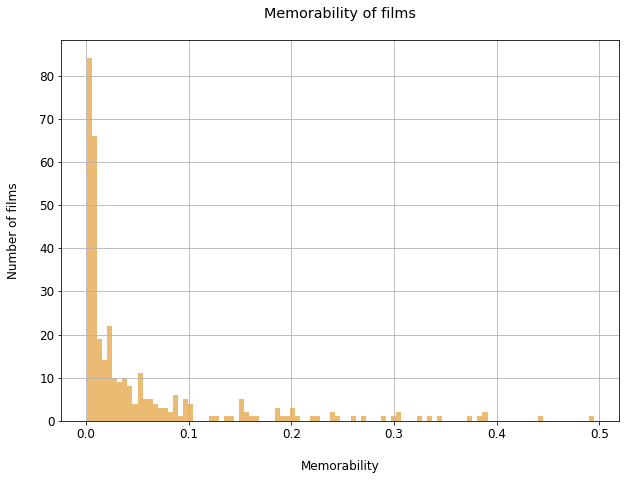

In [16]:
plt.rc('font', size=12) 

df_memorability_2018['memorability'].hist(bins = 100, 
                                     figsize=(10, 7),
                                    color = '#EBBB74')

plt.title("Memorability of films\n")
plt.ylabel("Number of films\n")
plt.xlabel("\nMemorability")

In [163]:
Few memorable movies, which was the outcome we expected.

Text(0.5, 1.0, "Memorability of all films related to speaker's gender\n")

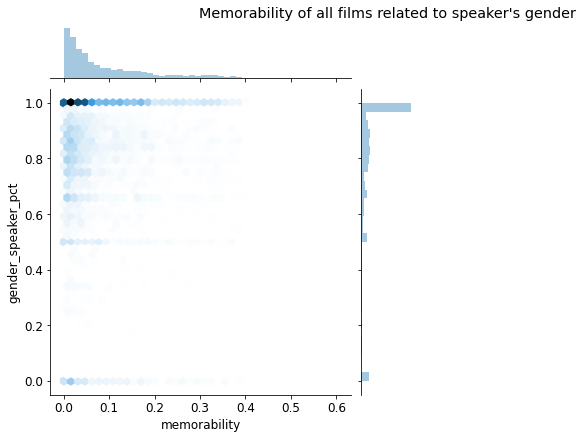

In [188]:
sns.jointplot(df_memorability['memorability'], df_memorability['gender_speaker_pct'], kind="hex")

plt.title("Memorability of all films related to speaker's gender\n", pad = 55)

Text(0.5, 1.0, "Memorability of films from 2018 related to speaker's gender\n")

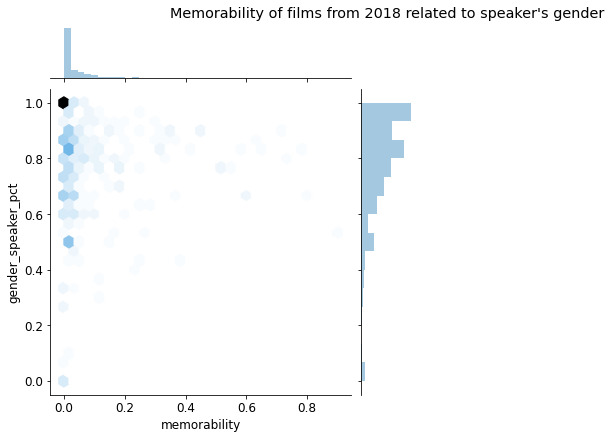

In [187]:
sns.jointplot(df_memorability_2018['memorability'], df_memorability_2018['gender_speaker_pct'], kind="hex")

plt.title("Memorability of films from 2018 related to speaker's gender\n", pad = 55)

/Users/Tupin/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Memorability of films from 2018 related to film crew gender\n')

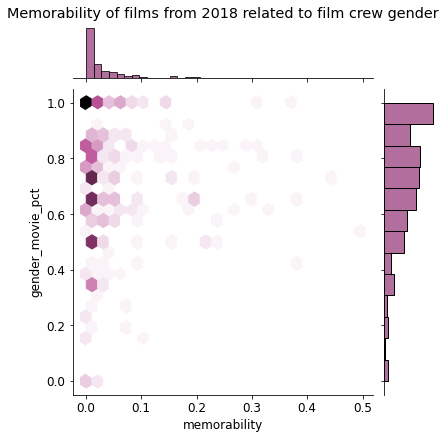

In [21]:
sns.jointplot(df_memorability_2018['memorability'], 
              df_memorability_2018['gender_movie_pct'], 
              kind="hex", 
             color = '#993D7B')

plt.title("Memorability of films from 2018 related to film crew gender\n", pad = 55)

In [165]:
#df_agg[df_agg['memorability'] > 0.4]
df_agg.sort_values(by = 'memorability', ascending = False).head(10)

,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability
20,tt0009454,Opportunity,831,0.825090,36702.519856,0.939164,36889.0,0,NaN,NaN,NaN,0,0.943936,0.0,NaN,0.0,0.780075,0.665794
212,tt0033780,Kathleen,1038,0.691626,28273.072254,0.723467,28486.0,0,NaN,NaN,NaN,0,0.728915,0.0,NaN,0.0,0.974624,0.606751
1850,tt0232048,Manmohan,861,0.956624,30143.574913,0.771330,30315.0,0,NaN,NaN,NaN,0,0.775716,0.0,NaN,0.0,0.808271,0.588829
1737,tt0202208,"$30,000",523,0.840077,35977.011472,0.920599,36158.0,0,NaN,NaN,NaN,0,0.925230,0.0,NaN,0.0,0.490602,0.584108
120,tt0022303,Reducing,712,0.847605,31953.087079,0.817633,32138.0,0,NaN,NaN,NaN,0,0.822364,0.0,NaN,0.0,0.668233,0.577058
265,tt0040007,Wyoming,999,0.869565,25882.174174,0.662287,26087.0,0,NaN,NaN,NaN,0,0.667528,0.0,NaN,0.0,0.937970,0.566946
1613,tt0173775,Drink,373,0.751366,37054.112601,0.948161,37250.0,0,NaN,NaN,NaN,0,0.953173,0.0,NaN,0.0,0.349624,0.562739
141,tt0024008,Female,679,0.403008,31229.228277,0.799110,31410.0,0,NaN,NaN,NaN,0,0.803736,0.0,NaN,0.0,0.637218,0.560016
47,tt0012822,Wealth,394,0.868217,35604.736041,0.911073,35788.0,0,NaN,NaN,NaN,0,0.915763,0.0,NaN,0.0,0.369361,0.549049
150,tt0025082,Emmy,615,0.643564,30893.048780,0.790508,31044.0,0,NaN,NaN,NaN,0,0.794371,0.0,NaN,0.0,0.577068,0.540487


In [166]:
#results not really concluant, so we try to focus on films from 2018.
df_memorability_2018['memorability'] = 0.05*df_memorability_2018['days_mean_norm'] + 0.05*df_memorability_2018['days_max_norm'] + 0.85*df_memorability_2018['nb_quote_month_norm'] + 0.05*df_memorability_2018['nb_quoteID_norm']
df_memorability_2018.sort_values(by = 'memorability', ascending = False).head(10) 

,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability
212,tt7491144,Amanda,1029,0.554337,167.923226,0.004297,364.0,101,0.000000,0.000000,0.0,0,0.009314,1.000000,0.000000,0.000000,0.966165,0.898989
69,tt5740866,Whitney,685,0.671598,99.810748,0.002554,229.0,92,63.379310,0.001622,134.0,60,0.005860,0.910891,0.072905,0.582524,0.642857,0.806821
77,tt5935704,Padmaavat,298,0.823729,89.312821,0.002285,339.0,91,5.319672,0.000136,23.0,103,0.008675,0.900990,0.012514,1.000000,0.279135,0.780346
234,tt7665608,Rwanda,693,0.799710,163.650794,0.004188,364.0,83,0.000000,0.000000,0.0,0,0.009314,0.821782,0.000000,0.000000,0.650376,0.731709
149,tt6787298,Leon,1065,0.908318,72.402817,0.001853,146.0,78,116.697183,0.002986,218.0,85,0.003736,0.772277,0.118607,0.825243,1.000000,0.706715
352,tt8512320,Target,892,0.821101,174.763453,0.004472,362.0,71,0.000000,0.000000,0.0,0,0.009263,0.702970,0.000000,0.000000,0.837406,0.640082
233,tt7655282,Medal,708,0.847578,164.706314,0.004215,346.0,71,8.250000,0.000211,18.0,27,0.008854,0.702970,0.009793,0.262136,0.664474,0.631402
140,tt6705860,Diane,717,0.666195,165.972106,0.004247,362.0,66,NaN,NaN,NaN,0,0.009263,0.653465,NaN,0.000000,0.672932,0.589768
47,tt5034122,Cruise,668,0.814590,183.887725,0.004705,357.0,66,NaN,NaN,NaN,0,0.009135,0.653465,NaN,0.000000,0.626880,0.587482
394,tt8917752,Joy,945,0.665955,66.494810,0.001702,123.0,64,131.410334,0.003363,240.0,59,0.003147,0.633663,0.130577,0.572816,0.887218,0.583217
